# PyTorch Image Classifier
通常来说，当你处理图像，文本，语音或者视频数据时，你可以使用标准python包将数据加载成numpy数组格式，然后将这个数组转换成torch.Tensor。

- 对于图像，可以使用Pillow，OpenCV
- 对于语音，可以使用scipy，librosa
- 对于文本，可以直接用Python或Cypthon基础数据加载模块，或者用NLTK和SpaCy。

特别是对于视觉，我们已经创建了一个叫做totchvision的包，**该包含有支持加载类似Imagenet, MINIST 等公共数据集的数据加载模块 torchvision.datasets 和支持家在图像数据转换模块 torch.utils.data.DataLoader**。

这提供了极大地便利，并且避免了编写样板代码。  

接下来，我们将使用CIFAR10数据集，它包含十个类别：'airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'。CIFAR-10中的图像尺寸为3×32×32，也就是RGB的3层的颜色通道，每层通道内的尺寸为32×32.由于是二维图像，图像维度为(3,32,32)。

![figure1](https://gitee.com/zyp521/upload_image/raw/master/pU83wM.png)

## 训练一个图像分类器
我们将按次序做如下几步：
- 使用torchvision加载并且归一化CIFAR10的训练和测试数据集
- 定义一个卷积神经网络
- 定义一个损失函数
- 在训练样本数据上训练网络
- 在测试样本数据上测试网络

### 数据处理
加载并归一化CIFAR10使用torchvision，用它来加载CIFAR10数据非常简单。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

torchvision数据集的输出是范围在[0,1]之间的PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量Tensors。

In [2]:
# 步骤整合，将转换为tensor和正则化整合到一起
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
# 数据集下载
trainset = torchvision.datasets.CIFAR10(root=os.path.join('/datasets'),train=True,download=True,transform=transform)
# 数据加载到Dataloader，batch_size=4，worker=2, shuffle为随机排序
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=1)
# 测试集下载
testset = torchvision.datasets.CIFAR10(root=os.path.join('/dataset'),train=False,download=True,transform=transform)
# 测试集加载
testloader = torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=1)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


下面来展示一下其中的一些训练图片。

tensor(2)


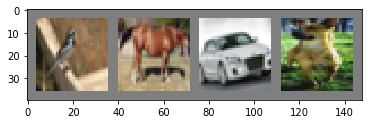

bird horse car dog


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_image(img):
    img = img / 2 + 0.5
    img = np.array(img)
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.show()

# get some random training image
dataiter = iter(trainloader) # load trainload to iteration
images, labels = dataiter.next()

print(labels[0]) # labels[0]对应的是序号
# show images
# make_grid的作用是将若干幅图像拼成一幅图像。其中padding的作用就是子图像与子图像之间的pad有多宽。
show_image(torchvision.utils.make_grid(images,padding=4))
# print label
print(' '.join('%s' %classes[labels[j]] for j in range(4)))

### 创建网络模型
将之前写好的卷积神经网络进行修改，改为能够使用三通道的图片的卷积神经网络。

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Create Model
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3,6,5) # input: 3 channels output: 6  filter:5×5
        self.conv2 = nn.Conv2d(6,16,5) # input: 6 output: 16
        # MaxPooling
        self.pool1 = nn.MaxPool2d(2,2) # 最大池化层
        self.pool2 = nn.MaxPool2d(2,2) # 最大池化层
        # Fully Connection Layers
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10) # 最后的10根据类的个数决定, 这里我们数据集包含了10个类
        
    def num_flat_features(self,x):
        """
        number of feature
        
        x:
        """
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def forward(self,x):
        # Max pooling over a (2,2) window
        # 过程说明:输入为(1,3,32,32)的向量，经过第一层卷积网络后得到维度为(4,6,28,28)的向量，然后经过2×2的池化，得到(4,6,14,14)的向量
        x = self.pool1(F.relu(self.conv1(x)))
        # If the size is a square you can onlu specify a single number
        x = self.pool2(F.relu(self.conv2(x))) # 经过第二次卷积和池化后得到(4,16,5,5)的向量
        # flatted
        x = x.view(-1,self.num_flat_features(x)) #偏平化操作得到(4,16*5*5)=（4，400）的向量
        # activate function
        x = F.relu(self.fc1(x)) # 通过第一层全连接层(4,400)变为(4，120)
        x = F.relu(self.fc2(x)) # 通过第二次全连接层(4,120)变为（4,84）
        x = self.fc3(x) # 通过最后一层全连接层(4,84)变为(14,10)
        return x

### 定义损失函数和优化器
让我们使用**分类交叉熵Cross-Entropy**作为损失函数，动量SGD做优化器

In [5]:
import torch.optim as optim

net = Net()

criterion = nn.CrossEntropyLoss() # criterion
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # SGD optimizer

### 训练网络
我们只需要在数据迭代器上循环传给网络和优化器，输入就可以。

In [6]:
# Net training parameters
epochs = 2
running_loss = 0.0

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        images, reference = data
        # initial parameter gradients
        optimizer.zero_grad()
        
        # forward
        hypothesis = net(images)
        # compute loss
        loss = criterion(hypothesis,reference)
        # backward
        loss.backward()
        # optimize
        optimizer.step()
        
        # print statistics
        running_loss += loss.item() # 累加loss
        # 每2000个块打印一次 loss平均值
        if i % 2000 == 1999:
            print('Epoch[{0}][{1}/{2}]\t'
                  'Loss-{loss_mean:.5f}'.format(epoch,i,len(trainloader),loss_mean=running_loss/2000))
            running_loss = 0.0
            
print('Finish training!')

Epoch[0][1999/12500]	Loss-2.20753
Epoch[0][3999/12500]	Loss-1.89217
Epoch[0][5999/12500]	Loss-1.70517
Epoch[0][7999/12500]	Loss-1.59354
Epoch[0][9999/12500]	Loss-1.51876
Epoch[0][11999/12500]	Loss-1.47544
Epoch[1][1999/12500]	Loss-1.39955
Epoch[1][3999/12500]	Loss-1.38140
Epoch[1][5999/12500]	Loss-1.32369
Epoch[1][7999/12500]	Loss-1.33968
Epoch[1][9999/12500]	Loss-1.29476
Epoch[1][11999/12500]	Loss-1.27259
Finish training!


### 在测试集上测试
我们将用神经网络的输出作为预测的类标来检查网络的预测性能，用样本的真实标签来校对。如果预测试正确的，我们将样本添加到正确预测的列表中。
#### 简单测试

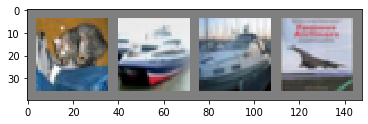

Reference:bird horse car dog


In [7]:
# get some random training image
dataiter = iter(testloader) # load trainload to iteration
images, reference = dataiter.next()

# show images
# make_grid的作用是将若干幅图像拼成一幅图像。其中padding的作用就是子图像与子图像之间的pad有多宽。
show_image(torchvision.utils.make_grid(images,padding=4))
# print label
print('Reference:'+' '.join('%s' %classes[labels[j]] for j in range(4)))

输入到网络中，得到预测值。

In [8]:
hypothesis = net(images)
print(hypothesis)

tensor([[-0.6298, -0.9711, -0.0604,  1.3519,  0.0415,  1.0961, -0.1623, -0.2242,
         -0.2655, -0.8728],
        [ 7.2373,  6.1067, -2.3502, -5.0919, -1.9855, -7.0024, -8.3972, -4.9735,
          9.4790,  4.1114],
        [ 3.8345,  3.0323, -1.4082, -2.3501, -1.3378, -3.7667, -5.1655, -2.4258,
          5.2440,  2.6135],
        [ 4.5255,  1.0029,  0.3899, -2.0903, -1.5415, -4.0133, -5.1938, -4.6442,
          9.2377,  0.2364]], grad_fn=<AddmmBackward>)


输出是预测与十个类的近似程度(softmax)，与某一个类的近似程度越高，网络就跃认为图像属于该类。

In [9]:
_, prediences = torch.max(hypothesis,1) # select the max value
print(prediences)
print('Predicted:' , ' '.join('%5s' %classes[prediences[j]] for j in range(4)))

tensor([3, 8, 8, 8])
Predicted:   cat  ship  ship  ship


下面我们将网络应用到整个测试集上，并且计算准确率。

In [10]:
correct = 0
total = 0

# 关闭梯度追踪
with torch.no_grad():
    for data in testloader:
        images, references = data
        outputs = net(images)
        _, hypothesis = torch.max(outputs,1)
        total += references.size(0)
        correct += (hypothesis == references).sum().item() # 添加item将tensor元素提取出来

print('Acuuracy of the network on the 10000 test images: %d%%' %(100 * correct / total))

Acuuracy of the network on the 10000 test images: 52%


下面我们来看一下网络对不同种类预测的正确率(共10种)：

In [17]:
class_total = torch.zeros(10,dtype=torch.float)
class_correct = torch.zeros(10,dtype=torch.float)

with torch.no_grad():
    for data in testloader:
        images, references = data
        outputs = net(images)
        _, hypothesis = torch.max(outputs,1)
        temp = (references == hypothesis).squeeze() # 将对比结果创建为tensor存储，由True和False组成
        for i in range(4):
            reference = references[i]
            add_num = 1
            if temp[i] == False:
                add_num = 0
            class_correct[reference] += add_num
            class_total[reference] += 1

for i in range(10):
    print('Accuracy of {cla} : {accur:.2f}%'.format(cla=classes[i],accur=100*class_correct[i]/class_total[i]))

Accuracy of plane : 40.80%
Accuracy of car : 71.50%
Accuracy of bird : 23.20%
Accuracy of cat : 29.20%
Accuracy of deer : 57.00%
Accuracy of dog : 48.50%
Accuracy of frog : 61.60%
Accuracy of horse : 56.50%
Accuracy of ship : 77.70%
Accuracy of truck : 63.70%


### GPU训练
如果你的电脑有英伟达的显卡，并且配置好了CUDA，以及PyTorch下载CUDA对应把进本才可以使用。下面是将首页被定义为首选使用GPU计算：

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


由于我电脑是只有CPU，所以接下来所有的代码均是在CPU上运行的。

In [20]:
net.to(device) # 网络使用cpu计算 如果你是GPU则是使用GPU计算

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

如果是GPU设备的话，会有相关方法递归的遍历所有模块，并将它们的参数和缓冲器转换为CUDA张量。  
**记住你也必须在每一步骤中向GPU发送输入和目标**

In [22]:
images, references = images.to(device),references.to(device)

如果你的网络规模很大的情况，GPU计算相对于CPU计算的加速效果十分明显。

对于GPU计算的好话，你需要将模型放到GPU中：  
```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
```

然后，你可以复制所有的张量到GPU中：  
```
tensor = tensor.to(device)
```

**注意**:只是调用tensor.to(device) 返回一个新的能够在GPU上计算的tensor，而不是重写。  

PyTorch默认只会使用一个GPU。通过使用DataParallel让你的模型并行运行，你可以在很容易的在多GPU上运行你的操作。  
```
model = nn.DataParallel(model)
```